In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Multilingual-MiniLM-L12-H384

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import re
# 1. Load and Prepare the Dataset
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 2. Load Your Data
# Assuming 'naijahate.csv' is the dataset file
train_df = pd.read_csv("/content/sample_data/main_df_train.csv")
test_df = pd.read_csv("/content/sample_data/main_df_test.csv")

In [ ]:
train_df["class"].value_counts()

,count
class,
0,7028
1,6264
2,5708


In [ ]:
test_df.head()

,class,text,language,clean_text
0,1,Ina so in ba da shit out to dukan fuckers,igbo,ina so in ba da shit out to dukan fuckers
1,2,Ị na-eme ka ndị Fulani na-azụ atụrụ bụrụ ndị a...,igbo,ị na-eme ka ndị fulani na-azụ atụrụ bụrụ ndị a...
2,0,"GO=&gt;LINK ★★FOLLOWME★IFOLLOWYOU✔,,,Sauye-sau...",igbo,"go=&gt;link followme ifollowyou ,,,sauye-sauy..."
3,2,Olee otú ndị ugwu ga-esi lanarị n'ụzọ akụ na ụ...,igbo,olee otú ndị ugwu ga-esi lanarị n'ụzọ akụ na ụ...
4,0,oga kafa ciwu a wurin nan🙈🙈,igbo,oga kafa ciwu a wurin nan


In [ ]:
test_df["class"].value_counts()

,count
class,
0,2972
1,2652
2,2524


In [ ]:
train_df.head()

,class,text,clean_text
0,2,"Innosson, Ibeto, Chinua Achebe, Chimamanda Adi...","innosson, ibeto, chinua achebe, chimamanda adi..."
1,2,Ṣé ìyẹn ń mú kó o ní èrò òdì?,ṣé ìyẹn ń mú kó o ní èrò òdì?
2,0,NYSC: National Year Of Sex And Comfort Episod...,nysc: national year of sex and comfort episode...
3,0,"Ọ bụ a sheel "": bụ Kim a Hoe____? ""","ọ bụ a sheel "": bụ kim a hoe____? """
4,2,"To, idan ka samu zabi ba za ka zabi ni ba?","to, idan ka samu zabi ba za ka zabi ni ba?"


In [ ]:
test_df.head()

,class,text,language,clean_text
0,1,Ina so in ba da shit out to dukan fuckers,igbo,ina so in ba da shit out to dukan fuckers
1,2,Ị na-eme ka ndị Fulani na-azụ atụrụ bụrụ ndị a...,igbo,ị na-eme ka ndị fulani na-azụ atụrụ bụrụ ndị a...
2,0,"GO=&gt;LINK ★★FOLLOWME★IFOLLOWYOU✔,,,Sauye-sau...",igbo,"go=&gt;link followme ifollowyou ,,,sauye-sauy..."
3,2,Olee otú ndị ugwu ga-esi lanarị n'ụzọ akụ na ụ...,igbo,olee otú ndị ugwu ga-esi lanarị n'ụzọ akụ na ụ...
4,0,oga kafa ciwu a wurin nan🙈🙈,igbo,oga kafa ciwu a wurin nan


In [ ]:
# Preprocess Data (e.g., extracting features and labels)
train_texts = train_df['clean_text'].values
train_labels = train_df['class'].values

val_texts = test_df['clean_text'].values
val_labels = test_df['class'].values

In [ ]:
# 3. Load Pre-trained XLM-R Tokenizer
# tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
MAX_LEN = 128

In [ ]:
#2. Load Pre-trained mBERT Tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer =  BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=3)

# MAX_LEN = 128

# Create DataLoaders
train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# # Create DataLoaders
# train_loader = DataLoader(train_texts, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_texts, batch_size=16, shuffle=False)

# 3. Initialize mBERT Model for Classification
# model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)  # Assuming 3 classes (hate, offensive, neutral)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 4. Set Up Optimizer and Scheduler
optimizer = torch.optim.AdamW([
    {'params': model.base_model.embeddings.parameters(), 'lr': 1e-5},
    {'params': model.base_model.encoder.layer[:6].parameters(), 'lr': 1e-5},
    {'params': model.base_model.encoder.layer[6:].parameters(), 'lr': 2e-5},
    {'params': model.classifier.parameters(), 'lr': 3e-5}
])
total_steps = len(train_loader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 6. Define Training and Evaluation Loops
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    total_loss = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(data_loader)

def eval_model(model, data_loader, device):
    model = model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# 7. Train the Model
accumulation_steps = 4  # Accumulate gradients over 4 batches

for epoch in range(10):
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / accumulation_steps  # Scale loss
        total_loss += loss.item()

        loss.backward()
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")
# 8. Evaluate the Model
preds, true_labels = eval_model(model, val_loader, device)

# Print Evaluation Report
print(classification_report(true_labels, preds))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.238093950255752
Epoch 2, Loss: 0.19321904597358672
Epoch 3, Loss: 0.16436599528649037
Epoch 4, Loss: 0.14128355314070828
Epoch 5, Loss: 0.12086595755904561
Epoch 6, Loss: 0.10266123476723579
Epoch 7, Loss: 0.08804454160258425
Epoch 8, Loss: 0.0767136244526641
Epoch 9, Loss: 0.06663470652451431
Epoch 10, Loss: 0.05896616783988684
              precision    recall  f1-score   support

           0       0.68      0.60      0.64      2972
           1       0.57      0.61      0.59      2652
           2       0.62      0.67      0.64      2524

    accuracy                           0.62      8148
   macro avg       0.62      0.62      0.62      8148
weighted avg       0.63      0.62      0.62      8148



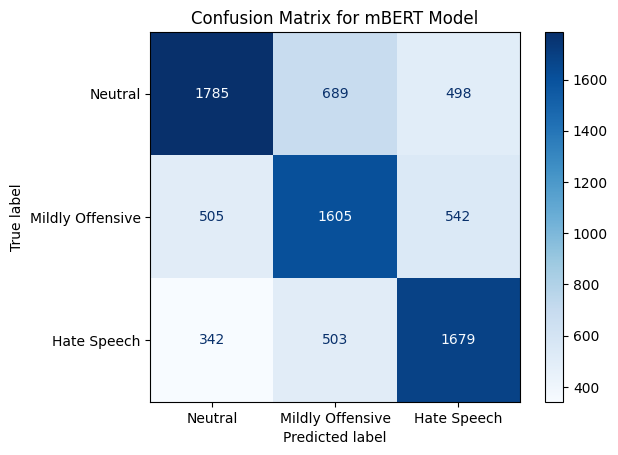

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Display the confusion matrix using a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Mildly Offensive', 'Hate Speech'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for mBERT Model')
plt.show()

In [ ]:
test_df = pd.read_csv("/content/sample_data/main_df_test.csv")

In [ ]:
igbo_df = test_df[test_df["language"]=="igbo"]
val_texts = igbo_df['clean_text'].values
val_labels = igbo_df['class'].values

val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, MAX_LEN)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 8. Evaluate the Model
preds, true_labels = eval_model(model, val_loader, device)

# Print Evaluation Report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61       743
           1       0.55      0.56      0.55       663
           2       0.59      0.64      0.62       631

    accuracy                           0.59      2037
   macro avg       0.59      0.59      0.59      2037
weighted avg       0.59      0.59      0.59      2037



In [ ]:
yor_df = test_df[test_df["language"]=="yoruba"]
val_texts = yor_df['clean_text'].values
val_labels = yor_df['class'].values

val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, MAX_LEN)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 8. Evaluate the Model
preds, true_labels = eval_model(model, val_loader, device)

# Print Evaluation Report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.62      0.54      0.58       743
           1       0.52      0.54      0.53       663
           2       0.56      0.62      0.59       631

    accuracy                           0.57      2037
   macro avg       0.57      0.57      0.57      2037
weighted avg       0.57      0.57      0.57      2037



In [ ]:
hau_df = test_df[test_df["language"]=="hausa"]
val_texts = hau_df['clean_text'].values
val_labels = hau_df['class'].values

val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, MAX_LEN)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 8. Evaluate the Model
preds, true_labels = eval_model(model, val_loader, device)

# Print Evaluation Report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.63      0.55      0.58       743
           1       0.55      0.60      0.57       663
           2       0.59      0.62      0.60       631

    accuracy                           0.59      2037
   macro avg       0.59      0.59      0.59      2037
weighted avg       0.59      0.59      0.59      2037



In [ ]:
eng_df = test_df[test_df["language"]=="english"]
val_texts = eng_df['clean_text'].values
val_labels = eng_df['class'].values

val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, MAX_LEN)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 8. Evaluate the Model
preds, true_labels = eval_model(model, val_loader, device)

# Print Evaluation Report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       743
           1       0.68      0.72      0.70       663
           2       0.73      0.79      0.76       631

    accuracy                           0.74      2037
   macro avg       0.75      0.75      0.74      2037
weighted avg       0.75      0.74      0.75      2037

